<a href="https://colab.research.google.com/github/ana-rlopez/ny_taxi_fare_prediction/blob/master/NYTaxiFare_1_ExploratoryAnalysis_%26_Preprocessing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [61]:
pip install xgboost

     |████████████████████████████████| 142.8MB 129kB/s eta 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [98]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sys
from geopy.distance import vincenty
import sklearn.feature_selection
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.dummy import DummyRegressor
from sklearn.preprocessing import StandardScaler
#from sklearn.preprocessing import RobustScaler
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from sklearn.model_selection import GridSearchCV

In [6]:
#from google.colab import drive
#drive.mount('/content/drive')
#train_path = '/content/drive/My Drive/Colab Notebooks/train.csv'
train_path = 'train.csv'

In [7]:
train = pd.read_csv(train_path, nrows=1_000_000) #we don't select all rows, since it is a big dataset
train.head()

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2009-06-15 17:26:21.0000001,4.5,2009-06-15 17:26:21 UTC,-73.844311,40.721319,-73.841610,40.712278,1
1,2010-01-05 16:52:16.0000002,16.9,2010-01-05 16:52:16 UTC,-74.016048,40.711303,-73.979268,40.782004,1
2,2011-08-18 00:35:00.00000049,5.7,2011-08-18 00:35:00 UTC,-73.982738,40.761270,-73.991242,40.750562,2
3,2012-04-21 04:30:42.0000001,7.7,2012-04-21 04:30:42 UTC,-73.987130,40.733143,-73.991567,40.758092,1
4,2010-03-09 07:51:00.000000135,5.3,2010-03-09 07:51:00 UTC,-73.968095,40.768008,-73.956655,40.783762,1


In [8]:
train.head()

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2009-06-15 17:26:21.0000001,4.5,2009-06-15 17:26:21 UTC,-73.844311,40.721319,-73.841610,40.712278,1
1,2010-01-05 16:52:16.0000002,16.9,2010-01-05 16:52:16 UTC,-74.016048,40.711303,-73.979268,40.782004,1
2,2011-08-18 00:35:00.00000049,5.7,2011-08-18 00:35:00 UTC,-73.982738,40.761270,-73.991242,40.750562,2
3,2012-04-21 04:30:42.0000001,7.7,2012-04-21 04:30:42 UTC,-73.987130,40.733143,-73.991567,40.758092,1
4,2010-03-09 07:51:00.000000135,5.3,2010-03-09 07:51:00 UTC,-73.968095,40.768008,-73.956655,40.783762,1


In [9]:
train.dtypes

key                   object
fare_amount          float64
pickup_datetime       object
pickup_longitude     float64
pickup_latitude      float64
dropoff_longitude    float64
dropoff_latitude     float64
passenger_count        int64
dtype: object

## Pre-processing (denoising data) and feature engineering

In [10]:
train['key'] = pd.to_datetime(train['key'])
train.dtypes

key                  datetime64[ns]
fare_amount                 float64
pickup_datetime              object
pickup_longitude            float64
pickup_latitude             float64
dropoff_longitude           float64
dropoff_latitude            float64
passenger_count               int64
dtype: object

In [11]:
#add features related with datetime
train['weekday'] = train['key'].dt.dayofweek

train['year']=train['key'].dt.year
train['month']=train['key'].dt.month
train['day']=train['key'].dt.day
train['hour']=train['key'].dt.hour
#train['minute']=train['key'].dt.minute #needed?
#train['second']=train['key'].dt.second

In [12]:
#check if there are some NaN values
train.columns[train.isna().any()].tolist()

['dropoff_longitude', 'dropoff_latitude']

In [13]:
#we drop these values given that the data set is quite big
#original rows: 1_000_000
train.dropna(inplace=True)
train.shape[0]

999990

In [14]:
#drop duplicates
train.drop_duplicates(keep = 'first', inplace = True)
train.shape[0]

999990

In [15]:
train.describe()
#check the describe to see if their values make sense

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,weekday,year,month,day,hour
count,999990.000000,999990.000000,999990.000000,999990.000000,999990.000000,999990.000000,999990.000000,999990.000000,999990.000000,999990.000000,999990.000000
mean,11.347953,-72.526699,39.929040,-72.527860,39.919954,1.684941,3.039870,2011.741103,6.267841,15.697996,13.509463
std,9.821790,12.057778,7.626087,11.324494,8.201418,1.323907,1.949966,1.860761,3.436230,8.682472,6.513855
min,-44.900000,-3377.680935,-3116.285383,-3383.296608,-3114.338567,0.000000,0.000000,2009.000000,1.000000,1.000000,0.000000
25%,6.000000,-73.992060,40.734965,-73.991385,40.734046,1.000000,1.000000,2010.000000,3.000000,8.000000,9.000000
50%,8.500000,-73.981792,40.752695,-73.980135,40.753166,1.000000,3.000000,2012.000000,6.000000,16.000000,14.000000
75%,12.500000,-73.967094,40.767154,-73.963654,40.768129,2.000000,5.000000,2013.000000,9.000000,23.000000,19.000000
max,500.000000,2522.271325,2621.628430,45.581619,1651.553433,208.000000,6.000000,2015.000000,12.000000,31.000000,23.000000


In [16]:
#based on these descriptors, we can at first sight already remove some outliers:
#1) Latitudes range from -90 to 90. Longitudes range from -180 to 180.
#2) passengers in a taxi, up to 6 (icnluding suvs) https://ride.guru/lounge/p/how-many-people-can-ride-in-a-cab 
#leave drives of 0 passengers in case documents are transported?
#3) fare has to be positive value, over 2.50$? (that seems to be the initial charge) https://www1.nyc.gov/site/tlc/passengers/taxi-fare.page
#also fare now seems too high (500) and the variance is pretty hight too. so we cut the max fare now

#4) new york city actually has the following bounding box of coordinates (https://boundingbox.klokantech.com/)
eastlimit_longitude=-73.700181
southlimit_latitude =40.47739894
westlimit_longitude=-74.25909
northlimit_latitude=40.916178         
                                                                                                               
train = train[ (train.pickup_longitude >= westlimit_longitude) & (train.pickup_longitude <= eastlimit_longitude) & \
              (train.dropoff_longitude >= westlimit_longitude) & (train.dropoff_longitude <= eastlimit_longitude) & \
              (train.pickup_latitude >= southlimit_latitude ) & (train.pickup_latitude <= northlimit_latitude) & \
              (train.dropoff_latitude >= southlimit_latitude) & (train.dropoff_latitude <= northlimit_latitude) & \
              (train.passenger_count<= 6) & \
              (train.fare_amount >= 2.50) ]                                                                              

#train = train[ (train.pickup_longitude >= -180) & (train.pickup_longitude <= 180) & \
#              (train.dropoff_longitude >= -180) & (train.dropoff_longitude <= 180) & \
#              (train.pickup_latitude >= -90) & (train.pickup_latitude <= 90) & \
#              (train.dropoff_latitude >= -90) & (train.dropoff_latitude <= 90) & \
#              (train.passenger_count<= 6) & \
#              (train.fare_amount > 2.50)  ]
    


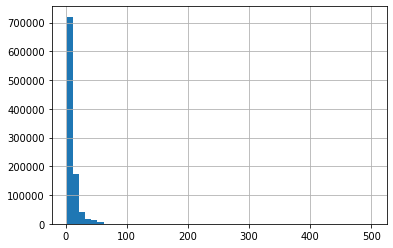

In [17]:
train.fare_amount.hist(bins=50)

In [18]:
train = train[ (train.fare_amount < 100)]

In [19]:
train.describe()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,weekday,year,month,day,hour
count,977645.000000,977645.000000,977645.000000,977645.000000,977645.000000,977645.000000,977645.000000,977645.000000,977645.000000,977645.000000,977645.000000
mean,11.266474,-73.975504,40.750870,-73.974565,40.751213,1.685273,3.039712,2011.739611,6.268954,15.692850,13.509751
std,9.295219,0.034370,0.026836,0.033850,0.030715,1.307981,1.949785,1.863163,3.437980,8.683036,6.510818
min,2.500000,-74.258821,40.482543,-74.258579,40.479537,0.000000,0.000000,2009.000000,1.000000,1.000000,0.000000
25%,6.000000,-73.992275,40.736587,-73.991571,40.735597,1.000000,1.000000,2010.000000,3.000000,8.000000,9.000000
50%,8.500000,-73.982092,40.753401,-73.980605,40.753859,1.000000,3.000000,2012.000000,6.000000,16.000000,14.000000
75%,12.500000,-73.968367,40.767541,-73.965390,40.768394,2.000000,5.000000,2013.000000,9.000000,23.000000,19.000000
max,99.750000,-73.700438,40.913110,-73.700390,40.916035,6.000000,6.000000,2015.000000,12.000000,31.000000,23.000000


In [20]:
#maybe convert time (hours and minutes) to circular, given that then the correlation may be more easily seen
#seconds_in_day = 24*60*60

#train['full_time'] = train.hour*60*60 + train.minute*60 + train.second #time of the day in seconds
#train['sin_time'] = np.sin(2*np.pi*train.full_time/seconds_in_day)
#train['cos_time'] = np.cos(2*np.pi*train.full_time/seconds_in_day)
#train.drop('full_time', axis=1, inplace=True)

#note: checked that these 2 feats are computed ok (proper ranges)

In [21]:
#Instead of doing Harvestine distance (that assumes Earth is a sphere), here Vincenty distance is used,
#which employs more accurate ellipsoidal models

# (latitude, longitude) reminder
train ['distance'] = train.apply(lambda x: vincenty((x['pickup_latitude'], x['pickup_longitude']), (x['dropoff_latitude'], x['dropoff_longitude'])).kilometers, axis = 1)

/home/a/miniconda2/envs/kernpy3/lib/python3.6/site-packages/ipykernel_launcher.py:5: DeprecationWarning: Vincenty is deprecated and is going to be removed in geopy 2.0. Use `geopy.distance.geodesic` (or the default `geopy.distance.distance`) instead, which is more accurate and always converges.
  """


In [22]:
train['distance'].describe()

count    977645.000000
mean          3.303950
std           3.539452
min           0.000000
25%           1.255057
50%           2.152355
75%           3.911568
max          43.621927
Name: distance, dtype: float64

In [23]:
train.describe().loc[['min','max']]

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,weekday,year,month,day,hour,distance
min,2.50,-74.258821,40.482543,-74.258579,40.479537,0.0,0.0,2009.0,1.0,1.0,0.0,0.000000
max,99.75,-73.700438,40.913110,-73.700390,40.916035,6.0,6.0,2015.0,12.0,31.0,23.0,43.621927


In [24]:
#there shouldn't be any distance equal to 0:
train = train[ (train.distance > 0)]
#log transform for distance helps
train['distance_log'] = train['distance'].transform(lambda x: np.log(x+sys.float_info.epsilon))

In [25]:
train.shape

(967489, 15)

## Data visualization (exploratory analysis)

/home/a/miniconda2/envs/kernpy3/lib/python3.6/site-packages/ipykernel_launcher.py:4: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  after removing the cwd from sys.path.


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f741e0dec18>,
      dtype=object)

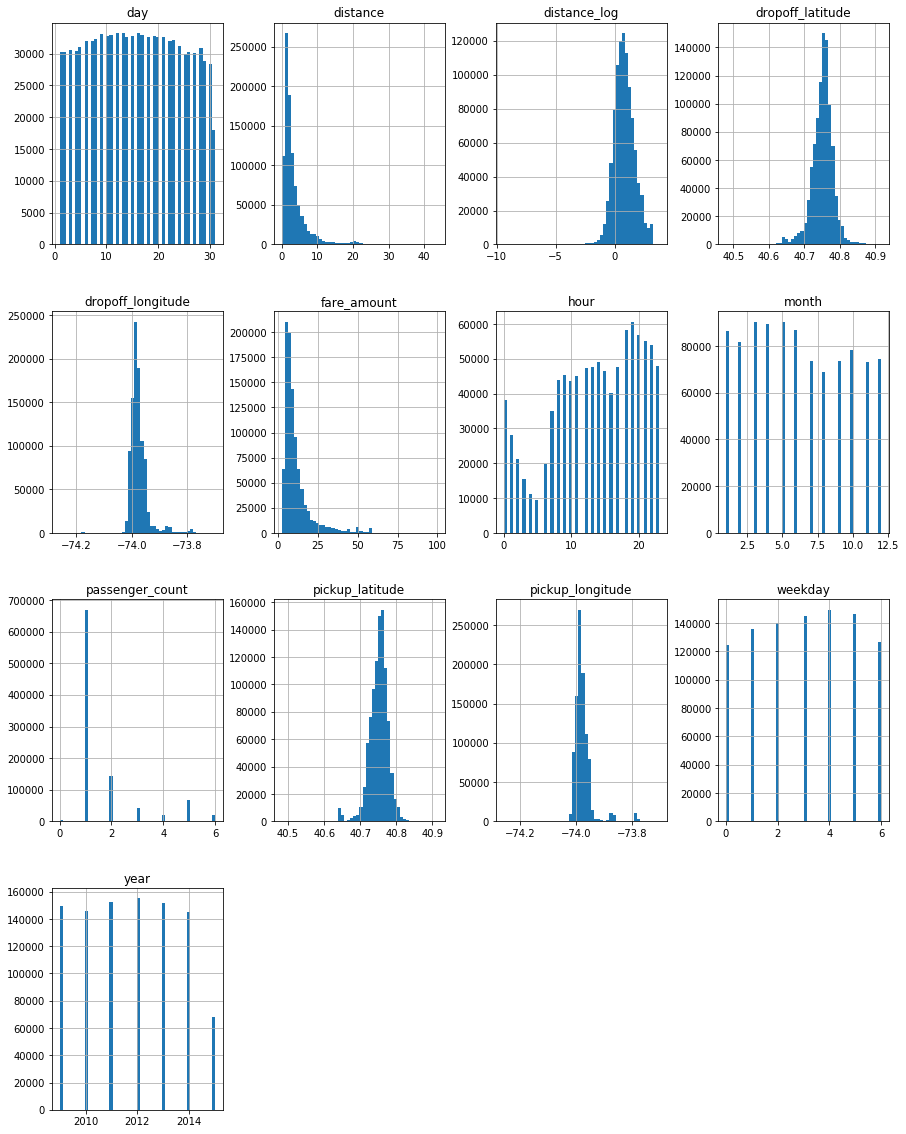

In [22]:
#check distributions of all the features
fig = plt.figure(figsize = (15,20))
ax = fig.gca()
train.hist(ax = ax, bins=50)


In [23]:
#Outlier removal, probably not needed

#Q1 = train.quantile(0.25)
#Q3 = train.quantile(0.75)
#IQR = Q3 - Q1

##automatic outlier removal, to try and get more normal distributions
##https://towardsdatascience.com/ways-to-detect-and-remove-the-outliers-404d16608dba?gi=8548f80fce4b
#train_out = train.drop(['key','pickup_datetime'],axis=1, inplace=False)
#
#train_out = train_out[~((train_out < (Q1 - 1.5 * IQR)) |(train_out > (Q3 + 1.5 * IQR))).any(axis=1)]

In [24]:
corr_pearson = train.corr(method='pearson')
mask = np.zeros_like(corr_pearson, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

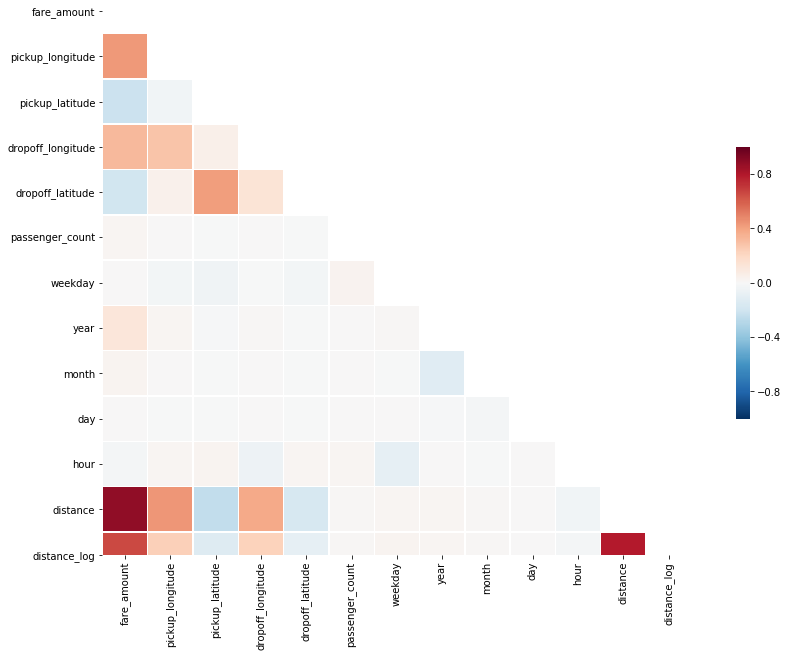

In [25]:
fig4, ax4 = plt.subplots(figsize=(16, 10))
sns.heatmap(corr_pearson, mask=mask, cmap='RdBu_r', vmax=1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5},vmin=-1)

In [26]:
#visualizer = FeatureCorrelation( method='mutual_info-classification', feature_names=train_out.columns, sort=True)
X = train.drop(['fare_amount','key','pickup_datetime'],axis=1, inplace=False).to_numpy()
Y = train.fare_amount.to_numpy()
#lab_enc = sklearn.preprocessing.LabelEncoder()
#Y_encoded = lab_enc.fit_transform(Y)

#mutual information has too expensive computationally to run for all data, so we just take 
X = X[1:100000,:]
Y = Y[1:100000]

feature_MIscores = sklearn.feature_selection.mutual_info_regression(X, Y)

#visualizer.fit(X, Y)        # Fit the data to the visualizer
#visualizer.show()              # Finalize and render the figure

In [27]:
feature_MIscores.shape

#plot also the fare vs the date (year), and maybe check as hypothesis if there is a positive correlation between year and fare

(12,)

([<matplotlib.axis.YTick at 0x7f8a34491f98>,
 <a list of 12 Text yticklabel objects>)

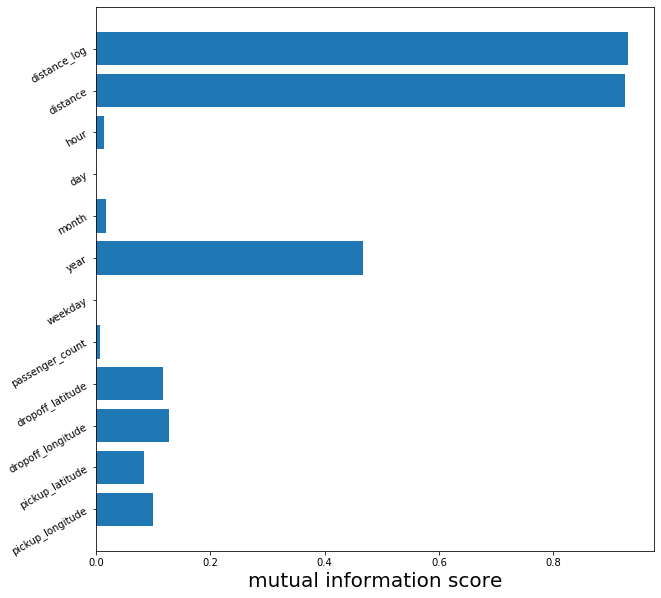

In [28]:
feats_labels = train.drop(['fare_amount','key','pickup_datetime'],axis=1, inplace=False).columns
#print(feats_labels)
index = np.arange(len(feats_labels))
plt.figure(figsize=(10,10))
plt.barh(index, feature_MIscores)
plt.xlabel('mutual information score', fontsize=20)
plt.yticks(index, feats_labels, fontsize=10, rotation=30)

In [29]:
#sns.pairplot(train, y_vars=['fare_amount'], x_vars=['distance', 'distance_log', 'hour','day','month','year','weekday','passenger_count','dropoff_latitude','dropoff_longitude','pickup_latitude','pickup_longitude'])

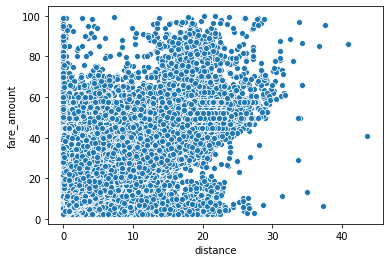

In [30]:
sns.scatterplot(x="distance", y="fare_amount", data=train)

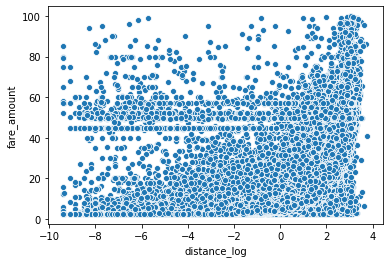

In [31]:
#there is also a kind of straight line, that can be explained by the flat rates used for taxi rides from airport
 #"Taxis at JFK Airport charge a flat fare of $52 for trips between the airport and Manhattan." 
#https://www.jfkairport.com/to-from-airport/taxi-car-and-van-service
sns.scatterplot(x="distance_log", y="fare_amount", data=train)

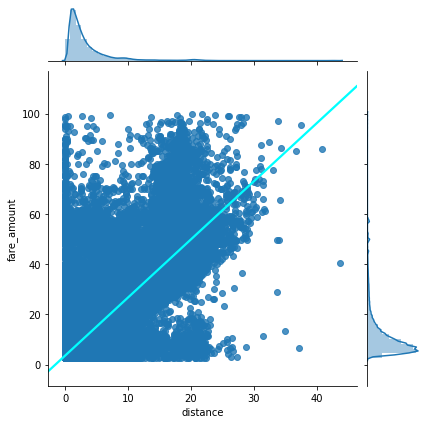

In [32]:
#using hex bins because regular scatter plot does not work (too many points)
sns.jointplot(x="distance", y="fare_amount", data=train, kind='reg',joint_kws={'line_kws':{'color':'cyan'}})

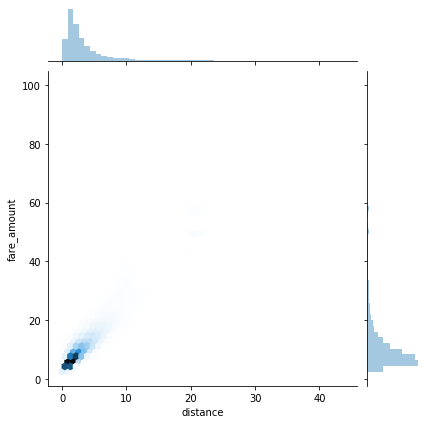

In [33]:
#using hex bins because regular scatter plot does not work (too many points)
#easier to see with dostance_log since the scale is shrunk
sns.jointplot(x="distance", y="fare_amount", data=train, kind='hex')

In [34]:
#TODO: maybe also plot histograms grouping by day, or by hour, to see what times are more common, and see if the fair is similar for 

In [35]:
#TODO:maybe a heat map of the fares would be interesting, doing a geomap, maybe use plotly?

In [36]:
#TODO: maybe employ clustering to get some extra information of the data, like outliers? 

## Split of training data (train + validation)

In [29]:
train2, val = train_test_split(train, test_size=0.3)

In [24]:
train.shape

(967489, 15)

In [25]:
train2.shape

(677242, 15)

In [26]:
train.columns

Index(['key', 'fare_amount', 'pickup_datetime', 'pickup_longitude',
       'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude',
       'passenger_count', 'weekday', 'year', 'month', 'day', 'hour',
       'distance', 'distance_log'],
      dtype='object')

In [27]:
val.shape

(290247, 15)

In [28]:
#val = pd.read_csv(train_path, skiprows=[2, 1_000_000], nrows=400_000)
#val.head()

In [29]:
#val.columns[val.isna().any()].tolist()

In [30]:
##now we add the same features that we did previously:
#val['key'] = pd.to_datetime(val['key'])
#val['weekday'] = val['key'].dt.dayofweek
#val['year']=val['key'].dt.year
#val['month']=val['key'].dt.month
#val['day']=val['key'].dt.day
#val['hour']=val['key'].dt.hour
#
##drop other
#val.drop(['key','pickup_datetime'],axis=1, inplace=True)

In [31]:
#val.columns[val.isna().any()].tolist()

In [32]:
#we don't remove NaN observations in the valiation test, because we want to be able to check how good it is 
#with all entries
#we use median rather than mean since it is more robust against outliers
#val.dropoff_longitude.fillna(val.dropoff_longitude.median(),inplace=True)
#val.dropoff_latitude.fillna(val.dropoff_latitude.median(),inplace=True)

In [33]:
#bounding the wrong coordinates (for distance computation)
#val.loc[val['pickup_longitude'] > 180, 'pickup_longitude'] = 180
#val.loc[val['pickup_longitude'] < -180, 'pickup_longitude'] = -180
#val.loc[val['dropoff_longitude'] > 180, 'dropoff_longitude'] = 180
#val.loc[val['dropoff_longitude'] < -180, 'dropoff_longitude'] = -180

#val.loc[val['pickup_latitude'] > 90, 'pickup_latitude'] = 90
#val.loc[val['pickup_latitude'] < -90, 'pickup_latitude'] = -90
#val.loc[val['dropoff_latitude'] > 90, 'dropoff_latitude'] = 90
#val.loc[val['dropoff_latitude'] < -90, 'dropoff_latitude'] = -90



In [34]:
#Instead of doing Harvestine distance (that assumes Earth is a sphere), here Vincenty distance is used,
#which employs more accurate ellipsoidal models

# (latitude, longitude) reminder
#val ['distance'] = val.apply(lambda y: vincenty((y['pickup_latitude'], y['pickup_longitude']), (y['dropoff_latitude'], y['dropoff_longitude'])).meters, axis = 1)

## Modeling 
### (Comparison of two regression models, plus a dummy model as baseline)

In [36]:
X_train = train2[['year','distance_log']]
y_train = train2[['fare_amount']]

X_val = val[['year','distance_log']]
y_val = val[['fare_amount']]

### Dummy model

In [57]:
dummy_regr = DummyRegressor(strategy="mean")
dummy_regr.fit(X_train, y_train)
y_valPred_dummy = dummy_regr.predict(X_val)
y_trainPred_dummy = dummy_regr.predict(X_train)

In [66]:
#R2 is the proportion of the variance in the dependent variable that is predictable from the independent
#variable(s).

r2_val_dummy = r2_score(y_val, y_valPred_dummy)
r2_train_dummy = r2_score(y_train, y_trainPred_dummy)

print('Dummy model- training, R2:' + str(r2_train_dummy))
print('Dummy model- validation, R2:' + str(r2_val_dummy))


Dummy model- training, R2:0.0
Dummy model- validation, R2:-1.911048189251474e-06


In [67]:
mse_val_dummy = mean_squared_error(y_val, y_valPred_dummy)
mse_train_dummy = mean_squared_error(y_train, y_trainPred_dummy)

print('Linear regression - training, MSE:' + str(mse_train_dummy))
print('Linear regression - validation, MSE:' + str(mse_val_dummy))

Linear regression - training, MSE:86.04865110545889
Linear regression - validation, MSE:85.45814674852882


### Linear regression

In [37]:
scaler = StandardScaler()
scaler.fit(X_train)

#use same scaler for both, based on X_train data
X_trainNorm = scaler.transform(X_train)
X_valNorm = scaler.transform(X_val)

In [77]:
#to normalize we use a robust scaler against outliers (same results as with standardScaler, but maybe for test is better
#robustScaler = RobustScaler()
#robustScaler.fit(X_train)
#X_trainNorm = robustScaler.transform(X_train)
#X_valNorm = robustScaler.transform(X_val)

In [68]:
# create linear regression model
linRegr = linear_model.LinearRegression()
print(linRegr)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)


In [80]:
# train the model with training data
linRegr.fit(X_trainNorm, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [81]:
y_valPred_linReg = linRegr.predict(X_valNorm) #to check validation error measures
y_trainPred_linReg = linRegr.predict(X_trainNorm) #to check training error measures

In [82]:
r2_val_linReg = r2_score(y_val, y_valPred_linReg)
r2_train_linReg = r2_score(y_train, y_trainPred_linReg)

print('Linear regression - training, R2:' + str(r2_train_linReg))
print('Linear regression - validation, R2:' + str(r2_val_linReg))


Linear regression - training, R2:0.4410582069249571
Linear regression - validation, R2:0.4461237684571465


In [83]:
mse_val_linReg = mean_squared_error(y_val, y_valPred_linReg)
mse_train_linReg = mean_squared_error(y_train, y_trainPred_linReg)

print('Linear regression - training, MSE:' + str(mse_train_linReg))
print('Linear regression - validation, MSE:' + str(mse_val_linReg))


Linear regression - training, MSE:48.09618734057396
Linear regression - validation, MSE:47.33314581978869


### Linear regression with Lasso regularization (i.e. feature selection)

In [30]:
train2.columns

Index(['key', 'fare_amount', 'pickup_datetime', 'pickup_longitude',
       'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude',
       'passenger_count', 'weekday', 'year', 'month', 'day', 'hour',
       'distance', 'distance_log'],
      dtype='object')

In [32]:
X_train_lasso = train2.drop(['fare_amount','key','pickup_datetime','distance'],axis=1, inplace=False)
y_train_lasso = train2[['fare_amount']]

X_val_lasso = val.drop(['fare_amount','key','pickup_datetime','distance'],axis=1, inplace=False)
y_val_lasso = val[['fare_amount']]

In [35]:
X_train_lasso.shape

(677242, 11)

In [36]:
y_train_lasso.shape

(677242, 1)

In [39]:
scaler_lasso = StandardScaler()
scaler_lasso.fit(X_train_lasso)

#use same scaler for both, based on X_train_lasso data
X_trainLassoNorm = scaler_lasso.transform(X_train_lasso)
X_valLassoNorm = scaler_lasso.transform(X_val_lasso)

In [40]:
lassoReg = linear_model.LassoCV()
lassoReg.fit(X_trainLassoNorm, y_train_lasso.values.ravel())

/home/a/miniconda2/envs/kernpy3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


LassoCV(alphas=None, copy_X=True, cv='warn', eps=0.001, fit_intercept=True,
        max_iter=1000, n_alphas=100, n_jobs=None, normalize=False,
        positive=False, precompute='auto', random_state=None,
        selection='cyclic', tol=0.0001, verbose=False)

In [42]:
y_valPred_lassoReg = lassoReg.predict(X_valLassoNorm)
y_trainPred_lassoReg = lassoReg.predict(X_trainLassoNorm)

In [46]:
r2_val_lassoReg = r2_score(y_val_lasso, y_valPred_lassoReg)
r2_train_lassoReg = r2_score(y_train_lasso, y_trainPred_lassoReg)

print('Linear regression with Lasso reg. - training, R2:' + str(r2_train_lassoReg))
print('Linear regression with Lasso reg. - validation, R2:' + str(r2_val_lassoReg))

Linear regression with Lasso reg. - training, R2:0.5719662853910872
Linear regression with Lasso reg. - validation, R2:0.5746397898289701


In [47]:
mse_val_lassoReg = mean_squared_error(y_val_lasso, y_valPred_lassoReg)
mse_train_lassoReg = mean_squared_error(y_train_lasso, y_trainPred_lassoReg)

print('Linear regression with Lasso reg. - training, MSE:' + str(mse_train_lassoReg))
print('Linear regression with Lasso reg. - validation, MSE:' + str(mse_val_lassoReg))

Linear regression with Lasso reg. - training, MSE:36.659284901011354
Linear regression with Lasso reg. - validation, MSE:36.75007388604558


### Random forest regression

Decision trees can deal with non-linearity relationships between independent variables and the dependent variable (fare_amount), unlike linear regressors.

In [56]:
randFor = RandomForestRegressor()

#decisions trees don't need normalized data since they don't assume any distribution
randFor.fit(X_train_lasso, y_train_lasso.values.ravel())

/home/a/miniconda2/envs/kernpy3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=10,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)

In [57]:
y_valPred_randFor = randFor.predict(X_val_lasso)
y_trainPred_randFor = randFor.predict(X_train_lasso)

In [58]:
r2_val_randFor = r2_score(y_val_lasso, y_valPred_randFor)
r2_train_randFor = r2_score(y_train_lasso, y_trainPred_randFor)

print('Random forest regression - training, R2:' + str(r2_train_randFor))
print('Random forest regression - validation, R2:' + str(r2_val_randFor))

Random forest regression - training, R2:0.9757256066926794
Random forest regression - validation, R2:0.8645826429201648


In [59]:
mse_val_randFor = mean_squared_error(y_val_lasso, y_valPred_randFor)
mse_train_randFor = mean_squared_error(y_train_lasso, y_trainPred_randFor)

print('Random forest regression - training, MSE:' + str(mse_train_randFor))
print('Random forest regression - validation, MSE:' + str(mse_val_randFor))

Random forest regression - training, MSE:2.0789995499895175
Random forest regression - validation, MSE:11.6997259243782


### XGBoost regression

With this approach with reduce not only variance (as in random forests) but also the bias.
It has also regularization to avoid overfitting.

In [90]:
# https://datascience.stackexchange.com/questions/23789/why-do-we-need-xgboost-and-random-forest
xgbr = xgb.XGBRegressor(objective ='reg:squarederror')  #objective changed based on warning: "reg:linear is now deprecated in favor of reg:squarederror."
print(xgbr)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
             n_jobs=1, nthread=None, objective='reg:squarederror',
             random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             seed=None, silent=None, subsample=1, verbosity=1)


In [92]:
#again here, using decision trees, so no need 
xgbr.fit(X_train_lasso, y_train_lasso.values.ravel())

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
             n_jobs=1, nthread=None, objective='reg:squarederror',
             random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             seed=None, silent=None, subsample=1, verbosity=1)

In [76]:
y_valPred_xgbr = xgbr.predict(X_val_lasso)
y_trainPred_xgbr = xgbr.predict(X_train_lasso)

In [78]:
r2_val_xgbr = r2_score(y_val_lasso, y_valPred_xgbr)
r2_train_xgbr = r2_score(y_train_lasso, y_trainPred_xgbr)

print('XGBoost regression - training, R2:' + str(r2_train_xgbr))
print('XGBoost regression - validation, R2:' + str(r2_val_xgbr))

XBoost regression - training, R2:0.8637202291088693
XBoost regression - validation, R2:0.8617769193325253


In [79]:
mse_val_xgbr = mean_squared_error(y_val_lasso, y_valPred_xgbr)
mse_train_xgbr = mean_squared_error(y_train_lasso, y_trainPred_xgbr)

print('XGBoost regression - training, MSE:' + str(mse_train_xgbr))
print('XGBoost forest regression - validation, MSE:' + str(mse_val_xgbr))

XBoost regression - training, MSE:11.671788405516615
XBoost forest regression - validation, MSE:11.94213352782591


- #### XGBoost with parameter tuning

In [82]:
# Parameters that are going to be tuned:
params = {
    'max_depth':3,
    'min_child_weight': 1,
    'learning_rate': 0.1,
    'subsample': 1,
    'colsample_bytree': 1,
    # Other parameters
    'objective':'reg:squarederror',
}
params['eval_metric'] = "mse"
num_boost_round = 999

In [93]:
#rather than panda daframes or numpy arrays, XGBoost uses DMatrices for train part
xgtrain = xgb.DMatrix(X_train_lasso, y_train_lasso.values)
xgtest = xgb.DMatrix(X_val_lasso)

In [94]:
#First we tune max_depth and min_child_weight (related with train data under/overfitting)
param_set1 = {
 'max_depth':range(3,10,2),
 'min_child_weight':range(1,6,2)
}

gsearch1 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=140, max_depth=5,
 min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=27), 
 param_grid = param_test1, scoring='roc_auc',n_jobs=4,iid=False, cv=5)